# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [178]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [1]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
project_name='02-insurance-linear-regression2023' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

  0%|          | 0/54288 [00:00<?, ?it/s]

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [6]:
your_name = 'Faisal'# at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
425,45,male,23.58070,5,no,10278.309195
607,59,female,22.94535,0,yes,26962.717373
428,21,female,16.31055,1,no,3325.828642
1142,52,female,24.11420,0,no,28473.893469
1121,46,male,37.02490,2,no,8764.522515


Let us answer some basic questions about the dataset. 


**Q1: How many rows does the dataset have?**

In [9]:
row_count = dataframe.shape[0]  # Returns number of rows

print(row_count)


1271


In [10]:
num_rows = 1271
print(num_rows)

1271


**Q2: How many columns doe the dataset have**

In [11]:
col_count = dataframe.shape[1]  # Returns number of columns
print(col_count)

6


In [12]:
num_cols = 6
print(num_cols)

6


**Q3: What are the column titles of the input variables?**

In [13]:
data_top = dataframe.head(20)
print(data_top)

      age     sex       bmi  children smoker       charges
425    45    male  23.58070         5     no  10278.309195
607    59  female  22.94535         0    yes  26962.717373
428    21  female  16.31055         1     no   3325.828642
1142   52  female  24.11420         0     no  28473.893469
1121   46    male  37.02490         2     no   8764.522515
152    32  female  36.03065         3     no   6651.060727
1262   41  female  27.20850         1     no   7108.702125
484    48    male  33.27100         3     no  10041.180450
738    23    male  30.77810         3    yes  37998.556785
114    52    male  31.23885         3     no  12062.732798
346    33    male  34.67750         2     no   5134.499475
621    37    male  33.07700         4    yes  42191.358300
241    33  female  21.47095         1     no   5621.778382
171    49    male  29.39100         0     no   8522.514000
277    22  female  23.57100         0     no   2257.992450
275    47  female  25.80200         2     no  10201.6330

In [53]:
input_cols = ['age','sex','bmi','children', 'smoker']

**Q4: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [54]:
df=dataframe

In [55]:
cols = df.columns
num_cols = df._get_numeric_data().columns

In [56]:
list(set(cols) - set(num_cols))

['sex', 'smoker']

In [57]:
categorical_cols = ['smoker','sex']

**Q5: What are the column titles of output/target variable(s)?**

In [58]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ai/aakashns/dataviz-cheatsheet

Minimum value of charges column 

In [59]:
# Write your answer here
#Minimum value of charges column
minValue = df['charges'].min()
print(minValue)

1177.967595


Maximum value of charges column 

In [60]:
maxValue = df['charges'].max()
print(maxValue)

66958.9494105


Average value of the charges column

In [61]:
avg_charges = df["charges"].mean()
print(avg_charges)

13885.372412642762


Showing distribution of values in a graph

In [62]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Configuring styles
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [64]:
charges_list = df['charges'].tolist()
  
# show the list
print('Charges ',charges_list)
age_list=df['age'].tolist()
print('Age ',age_list)
children_list=df['children'].tolist()
print(children_list)
bmi_list=df['bmi'].tolist()
print('bmi ',bmi_list)

Charges  [10278.309195000002, 26962.717372500003, 3325.8286424999997, 28473.893469000002, 8764.522515, 6651.060727499999, 7108.702125, 10041.18045, 37998.556785, 12062.7327975, 5134.4994750000005, 42191.3583, 5621.778382499999, 8522.514000000001, 2257.9924499999997, 10201.63305, 1758.363915, 3319.5267000000003, 6900.1212, 2128.322805, 7179.237134999999, 5531.2090575, 7556.71035, 35595.68565, 18229.854405000002, 29892.364960500003, 20516.205149999998, 7399.05831, 14839.6896375, 8630.164095, 5069.300197500001, 5128.0593, 22255.608900000003, 9378.6882, 12429.018, 24403.5482565, 11708.319000000001, 57892.17219450001, 2559.9579599999997, 30999.323879999996, 21010.115332499998, 8644.752375, 20471.5551285, 42756.5786025, 6940.615185, 31694.183534999996, 2438.7528899999998, 1602.6275999999998, 5263.09455, 3330.6189, 14615.814045, 8117.998454999999, 55220.3708595, 24218.691735, 36018.325560000005, 11470.129860000001, 6780.735570000001, 18772.845714, 39133.65876, 11864.310150000001, 4189.33305, 

Text(0.5, 1.0, 'Age vs charges')

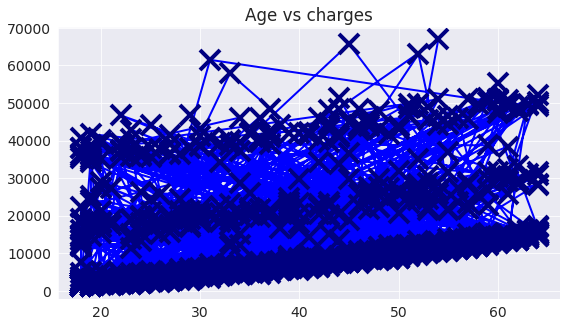

In [65]:
# First line
plt.plot(age_list, charges_list, 'b-x', linewidth=2, markersize=20, markeredgewidth=4, markeredgecolor='navy')



# Title
plt.title('Age vs charges')



Text(0.5, 1.0, 'Bmi vs charges')

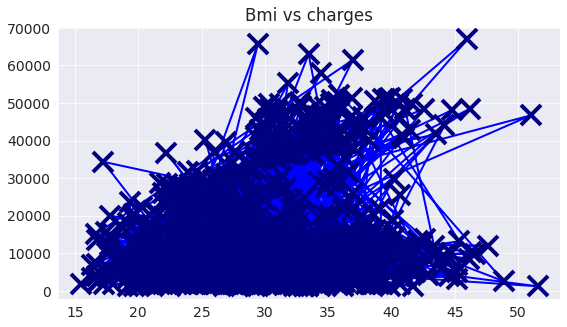

In [66]:
# First line
plt.plot(bmi_list, charges_list, 'b-x', linewidth=2, markersize=20, markeredgewidth=4, markeredgecolor='navy')



# Title
plt.title('Bmi vs charges')

Text(0.5, 1.0, 'Children vs charges')

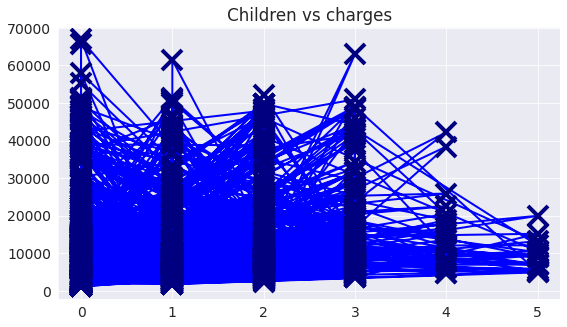

In [67]:
# First line
plt.plot(children_list, charges_list, 'b-x', linewidth=2, markersize=20, markeredgewidth=4, markeredgecolor='navy')



# Title
plt.title('Children vs charges')

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [68]:
!pip install jovian --upgrade -q

In [69]:
import jovian

In [70]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [71]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [72]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[45.     ,  1.     , 23.5807 ,  5.     ,  0.     ],
        [59.     ,  0.     , 22.94535,  0.     ,  1.     ],
        [21.     ,  0.     , 16.31055,  1.     ,  0.     ],
        ...,
        [42.     ,  1.     , 27.4607 ,  3.     ,  1.     ],
        [42.     ,  1.     , 24.1142 ,  0.     ,  0.     ],
        [29.     ,  1.     , 36.1713 ,  2.     ,  0.     ]]),
 array([[10278.309195 ],
        [26962.7173725],
        [ 3325.8286425],
        ...,
        [34426.8315195],
        [ 6265.23177  ],
        [ 4261.021905 ]]))

**Q6: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [73]:
inputs =  torch.Tensor(inputs_array)
targets =  torch.Tensor(targets_array)

In [74]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [75]:
dataset = TensorDataset(inputs, targets)

**Q7: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [76]:
val_percent = 0.19 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
print(val_size)
print(train_size)


train_ds, val_ds =random_split(dataset, [1030, 241])  # Use the random_split function to split dataset into 2 parts of the desired length

241
1030


Finally, we can create data loaders for training & validation.

**Q8: Pick a batch size for the data loader.**

In [144]:
batch_size = 32

In [145]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [146]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[43.0000,  1.0000, 36.9182,  2.0000,  1.0000],
        [64.0000,  1.0000, 37.0443,  0.0000,  0.0000],
        [26.0000,  0.0000, 19.2060,  1.0000,  0.0000],
        [21.0000,  1.0000, 19.6280,  3.0000,  0.0000],
        [62.0000,  0.0000, 36.9521,  2.0000,  0.0000],
        [18.0000,  1.0000, 21.1266,  2.0000,  0.0000],
        [34.0000,  1.0000, 21.7474,  2.0000,  0.0000],
        [41.0000,  1.0000, 39.0522,  0.0000,  0.0000],
        [34.0000,  1.0000, 27.0000,  1.0000,  1.0000],
        [61.0000,  1.0000, 31.3310,  2.0000,  0.0000],
        [49.0000,  0.0000, 26.3549,  0.0000,  0.0000],
        [40.0000,  1.0000, 33.0818,  1.0000,  0.0000],
        [51.0000,  0.0000, 33.0770,  0.0000,  0.0000],
        [51.0000,  0.0000, 33.1740,  1.0000,  0.0000],
        [31.0000,  0.0000, 28.3822,  1.0000,  0.0000],
        [22.0000,  0.0000, 27.2085,  0.0000,  0.0000],
        [28.0000,  1.0000, 23.5710,  5.0000,  0.0000],
        [40.0000,  1.0000, 22.0238,  2.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [147]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [148]:
input_size = len(input_cols)
output_size = len(output_cols)
print(input_size)

5


**Q9: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [149]:
loss_fn = F.mse_loss

In [158]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  
        
    def forward(self, xb):
        out = self.linear(xb)                      
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                        
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)               
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [159]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [160]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1354,  0.0418, -0.2582, -0.3388, -0.3350]], requires_grad=True),
 Parameter containing:
 tensor([-0.1211], requires_grad=True)]

One final commit before we train the model.

In [161]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [162]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q10: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [163]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14648.7197265625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q11: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [164]:
epochs = 100
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8517.9326
Epoch [40], val_loss: 8426.3594
Epoch [60], val_loss: 8351.9570
Epoch [80], val_loss: 8284.8750
Epoch [100], val_loss: 8224.5186


In [165]:
epochs = 500
lr = 1e-4
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8223.9346
Epoch [40], val_loss: 8223.3506
Epoch [60], val_loss: 8222.7559
Epoch [80], val_loss: 8222.1641
Epoch [100], val_loss: 8221.5742
Epoch [120], val_loss: 8220.9902
Epoch [140], val_loss: 8220.3975
Epoch [160], val_loss: 8219.8164
Epoch [180], val_loss: 8219.2314
Epoch [200], val_loss: 8218.6445
Epoch [220], val_loss: 8218.0566
Epoch [240], val_loss: 8217.4736
Epoch [260], val_loss: 8216.9023
Epoch [280], val_loss: 8216.3242
Epoch [300], val_loss: 8215.7471
Epoch [320], val_loss: 8215.1748
Epoch [340], val_loss: 8214.6016
Epoch [360], val_loss: 8214.0186
Epoch [380], val_loss: 8213.4443
Epoch [400], val_loss: 8212.8594
Epoch [420], val_loss: 8212.2754
Epoch [440], val_loss: 8211.6973
Epoch [460], val_loss: 8211.1328
Epoch [480], val_loss: 8210.5625
Epoch [500], val_loss: 8209.9980


In [166]:
epochs = 700
lr = 1e-7
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8209.9980
Epoch [40], val_loss: 8209.9971
Epoch [60], val_loss: 8209.9961
Epoch [80], val_loss: 8209.9961
Epoch [100], val_loss: 8209.9961
Epoch [120], val_loss: 8209.9951
Epoch [140], val_loss: 8209.9961
Epoch [160], val_loss: 8209.9951
Epoch [180], val_loss: 8209.9941
Epoch [200], val_loss: 8209.9941
Epoch [220], val_loss: 8209.9941
Epoch [240], val_loss: 8209.9932
Epoch [260], val_loss: 8209.9932
Epoch [280], val_loss: 8209.9932
Epoch [300], val_loss: 8209.9922
Epoch [320], val_loss: 8209.9922
Epoch [340], val_loss: 8209.9912
Epoch [360], val_loss: 8209.9912
Epoch [380], val_loss: 8209.9912
Epoch [400], val_loss: 8209.9902
Epoch [420], val_loss: 8209.9902
Epoch [440], val_loss: 8209.9902
Epoch [460], val_loss: 8209.9902
Epoch [480], val_loss: 8209.9883
Epoch [500], val_loss: 8209.9893
Epoch [520], val_loss: 8209.9883
Epoch [540], val_loss: 8209.9883
Epoch [560], val_loss: 8209.9883
Epoch [580], val_loss: 8209.9873
Epoch [600], val_loss: 8209.9873
Epoch [620], v

In [167]:
epochs = 1000
lr = 1e-4
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8209.4102
Epoch [40], val_loss: 8208.8311
Epoch [60], val_loss: 8208.2510
Epoch [80], val_loss: 8207.6797
Epoch [100], val_loss: 8207.1016
Epoch [120], val_loss: 8206.5273
Epoch [140], val_loss: 8205.9600
Epoch [160], val_loss: 8205.3857
Epoch [180], val_loss: 8204.8135
Epoch [200], val_loss: 8204.2373
Epoch [220], val_loss: 8203.6602
Epoch [240], val_loss: 8203.0781
Epoch [260], val_loss: 8202.5000
Epoch [280], val_loss: 8201.9297
Epoch [300], val_loss: 8201.3447
Epoch [320], val_loss: 8200.7695
Epoch [340], val_loss: 8200.1973
Epoch [360], val_loss: 8199.6211
Epoch [380], val_loss: 8199.0557
Epoch [400], val_loss: 8198.4941
Epoch [420], val_loss: 8197.9170
Epoch [440], val_loss: 8197.3486
Epoch [460], val_loss: 8196.7842
Epoch [480], val_loss: 8196.2178
Epoch [500], val_loss: 8195.6543
Epoch [520], val_loss: 8195.0938
Epoch [540], val_loss: 8194.5361
Epoch [560], val_loss: 8193.9736
Epoch [580], val_loss: 8193.4131
Epoch [600], val_loss: 8192.8516
Epoch [620], v

In [168]:
epochs = 5000
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8181.2051
Epoch [40], val_loss: 8180.6479
Epoch [60], val_loss: 8180.1025
Epoch [80], val_loss: 8179.6050
Epoch [100], val_loss: 8179.1211
Epoch [120], val_loss: 8178.6240
Epoch [140], val_loss: 8178.1343
Epoch [160], val_loss: 8177.6411
Epoch [180], val_loss: 8177.1465
Epoch [200], val_loss: 8176.6577
Epoch [220], val_loss: 8176.1709
Epoch [240], val_loss: 8175.6904
Epoch [260], val_loss: 8175.1997
Epoch [280], val_loss: 8174.7246
Epoch [300], val_loss: 8174.2485
Epoch [320], val_loss: 8173.7637
Epoch [340], val_loss: 8173.2744
Epoch [360], val_loss: 8172.7788
Epoch [380], val_loss: 8172.2861
Epoch [400], val_loss: 8171.8101
Epoch [420], val_loss: 8171.3320
Epoch [440], val_loss: 8170.8599
Epoch [460], val_loss: 8170.3862
Epoch [480], val_loss: 8169.9233
Epoch [500], val_loss: 8169.4526
Epoch [520], val_loss: 8168.9756
Epoch [540], val_loss: 8168.5103
Epoch [560], val_loss: 8168.0146
Epoch [580], val_loss: 8167.5332
Epoch [600], val_loss: 8167.0474
Epoch [620], v

In [169]:
epochs = 10000
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8086.2212
Epoch [40], val_loss: 8085.9360
Epoch [60], val_loss: 8085.6284
Epoch [80], val_loss: 8085.3184
Epoch [100], val_loss: 8085.0278
Epoch [120], val_loss: 8084.7271
Epoch [140], val_loss: 8084.4795
Epoch [160], val_loss: 8084.2280
Epoch [180], val_loss: 8083.9717
Epoch [200], val_loss: 8083.7324
Epoch [220], val_loss: 8083.4663
Epoch [240], val_loss: 8083.1841
Epoch [260], val_loss: 8082.8813
Epoch [280], val_loss: 8082.6001
Epoch [300], val_loss: 8082.3364
Epoch [320], val_loss: 8082.1162
Epoch [340], val_loss: 8081.8833
Epoch [360], val_loss: 8081.6147
Epoch [380], val_loss: 8081.3564
Epoch [400], val_loss: 8081.1143
Epoch [420], val_loss: 8080.8384
Epoch [440], val_loss: 8080.5449
Epoch [460], val_loss: 8080.2661
Epoch [480], val_loss: 8079.9863
Epoch [500], val_loss: 8079.6919
Epoch [520], val_loss: 8079.4268
Epoch [540], val_loss: 8079.1431
Epoch [560], val_loss: 8078.8872
Epoch [580], val_loss: 8078.5894
Epoch [600], val_loss: 8078.3032
Epoch [620], v

**Q12: What is the final validation loss of your model?**

In [170]:
val_loss = 8027.0518

Let's log the final validation loss to Jovian and commit the notebook

In [171]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Metrics logged.


In [172]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q13: Complete the following function definition to make predictions on a single input**

In [173]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [174]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([19.0000,  0.0000, 23.8668,  1.0000,  0.0000])
Target: tensor([2844.7061])
Prediction: tensor([3103.2520])


In [175]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([45.0000,  1.0000, 23.3139,  2.0000,  0.0000])
Target: tensor([9034.7080])
Prediction: tensor([9885.1758])


In [176]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([20.0000,  1.0000, 26.4810,  0.0000,  1.0000])
Target: tensor([17044.4902])
Prediction: tensor([3157.7856])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [177]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
